# Decomposition Using mCG-5Kb Bins

## Content


## Input
- MCDS file
- Cell metadata

## Output
- Cell-by-5kb-bin AnnData (sparse matrix) with embedding coordinates and cluster labels.

## Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc

from ALLCools.clustering import (
    tsne, significant_pc_test, filter_regions, lsi, binarize_matrix
)
from ALLCools.plot import *
from ALLCools.mcds import MCDS

In [2]:
from ALLCools.dataset import ALLCoolsDataset

brain_dataset = ALLCoolsDataset('/gale/netapp/cemba3c/projects/ALLCools/Brain/snmC-seq2/')

## Load Cell Metadata

In [3]:
metadata = pd.read_csv(brain_dataset.metadata_path, index_col=0)
print(f'Metadata of {metadata.shape[0]} cells')
metadata.head()

Metadata of 4875 cells


AllcPath  mCCCFrac  \
8E_M_10    /gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-1...  0.005505   
8E_M_100   /gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-1...  0.004702   
8E_M_1000  /gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-3...  0.005423   
8E_M_1002  /gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-3...  0.004117   
8E_M_1003  /gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-3...  0.005528   

            mCGFrac  mCGFracAdj   mCHFrac  mCHFracAdj  FinalReads  InputReads  \
8E_M_10    0.744279    0.742863  0.020649    0.015228   2714916.0     6036476   
8E_M_100   0.723100    0.721792  0.012400    0.007735   3302547.0     7683706   
8E_M_1000  0.739960    0.738542  0.021733    0.016399   1369094.0     3658050   
8E_M_1002  0.745511    0.744459  0.010192    0.006101   4571390.0    11822434   
8E_M_1003  0.750461    0.749074  0.023083    0.017652   1334845.0     3479288   

           MappedReads DissectionRegion  BamFilteringRate  MappingRate  \
8E_M_10      4014048.0               8E          0.676354     0.664965   
8E_M_100     5370970.0               8E          0.614888     0.699008   
8E_M_1000    2381916.0               8E          0.574787     0.651144   
8E_M_1002    8079217.0               8E          0.565821     0.683380   
8E_M_1003    2337068.0               8E          0.571162     0.671709   

                      Plate  Col384  Row384  FANSDate  Slice     Sample  
8E_M_10    CEMBA190711-8E-1      19       0    190711      8  8E_190711  
8E_M_100   CEMBA190711-8E-2       1       2    190711      8  8E_190711  
8E_M_1000  CEMBA190711-8E-4       6       5    190711      8  8E_190711  
8E_M_1002  CEMBA190711-8E-4       7       5    190711      8  8E_190711  
8E_M_1003  CEMBA190711-8E-3       8       4    190711      8  8E_190711

## Load MCAD

In [4]:
mcds = MCDS.open(brain_dataset.mcds_paths,
                 use_obs=metadata.index,
                 var_dim='chrom5k')
mcds.add_cell_metadata(metadata)

In [6]:
mcds = mcds.remove_black_list_region(black_list_path=brain_dataset.metadata_dir / 'mm10-blacklist.v2.bed.gz')

49908 chrom5k features removed due to overlapping (bedtools intersect -f 0.2) with black list regions.


In [7]:
mcds = mcds.remove_chromosome(exclude_chromosome=['chrM', 'chrY'])

893 chrom5k features in ['chrM', 'chrY'] removed.


In [8]:
mcad = mcds.get_score_adata(mc_type='CGN', quant_type='hypo-score')
mcad

Loading chunk 0-4875/4875


AnnData object with n_obs × n_vars = 4875 × 494317
    obs: 'AllcPath', 'mCCCFrac', 'mCGFrac', 'mCGFracAdj', 'mCHFrac', 'mCHFracAdj', 'FinalReads', 'InputReads', 'MappedReads', 'DissectionRegion', 'BamFilteringRate', 'MappingRate', 'Plate', 'Col384', 'Row384', 'FANSDate', 'Slice', 'Sample'
    var: 'chrom', 'end', 'start'

## Binarize

In [9]:
binarize_matrix(mcad, cutoff=0.95)

## Filter Features

In [10]:
filter_regions(mcad)

252901 regions remained.


In [11]:
mcad

AnnData object with n_obs × n_vars = 4875 × 252901
    obs: 'AllcPath', 'mCCCFrac', 'mCGFrac', 'mCGFracAdj', 'mCHFrac', 'mCHFracAdj', 'FinalReads', 'InputReads', 'MappedReads', 'DissectionRegion', 'BamFilteringRate', 'MappingRate', 'Plate', 'Col384', 'Row384', 'FANSDate', 'Slice', 'Sample'
    var: 'chrom', 'end', 'start'

## LSI Decomposition

### Run LSI

In [16]:
lsi(mcad, algorithm='arpack', obsm='X_lsi')

# choose significant components
n_components = significant_pc_test(mcad, obsm='X_lsi', p_cutoff=0.1, update=True)

10 components passed P cutoff of 0.1.
Changing adata.obsm['X_pca'] from shape (4875, 100) to (4875, 10)


### Plot

Red axis labels are used PCs


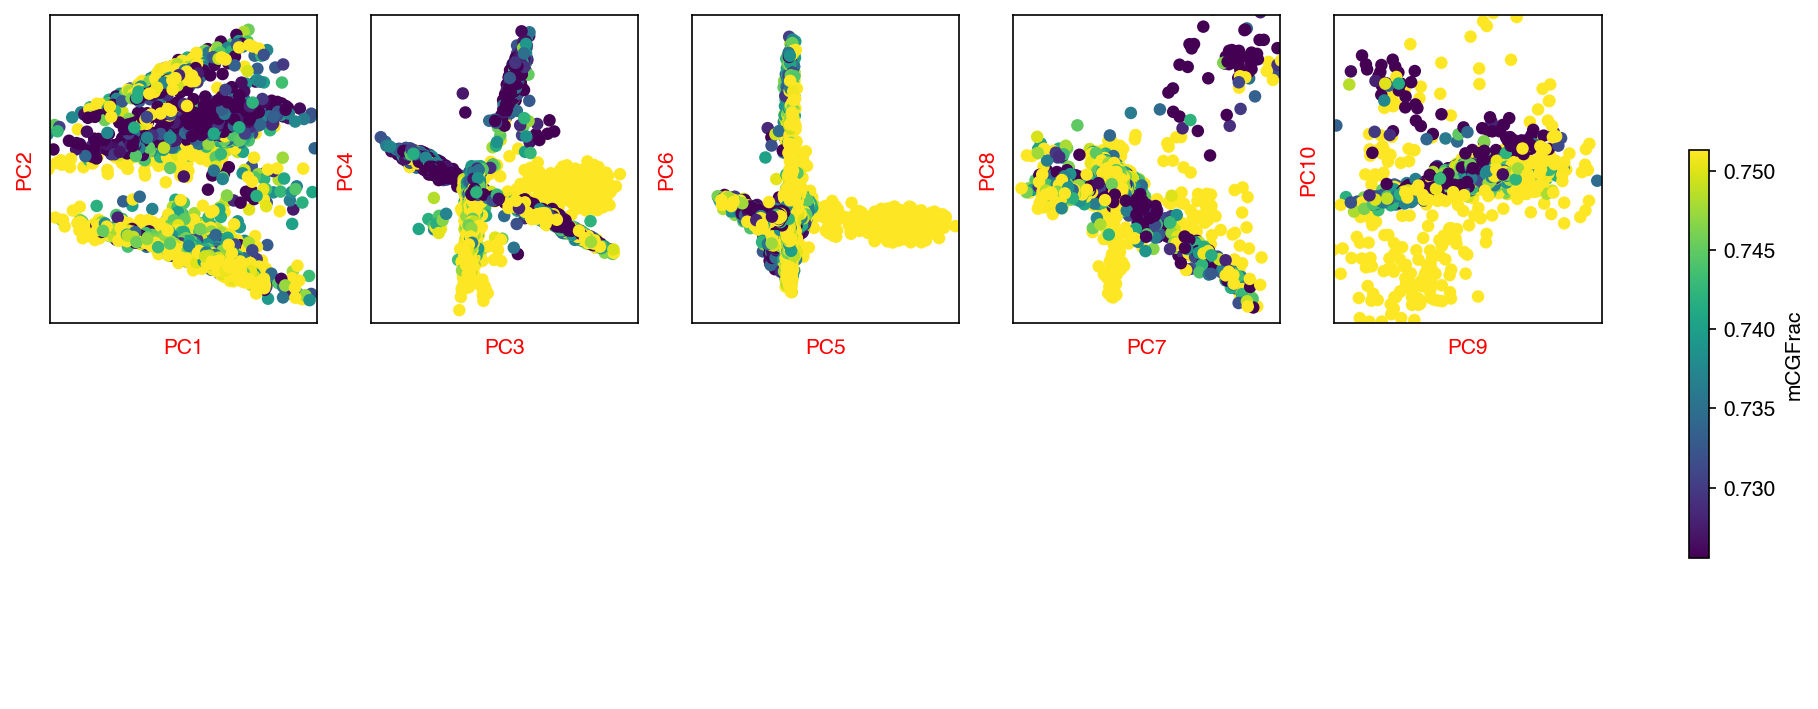

In [17]:
hue = 'mCGFrac'
if hue in metadata.columns:
    mcad.obs[hue] = metadata[hue].reindex(mcad.obs_names)
    fig, axes = plot_decomp_scatters(mcad,
                                     n_components=n_components,
                                     obsm_name='X_lsi',
                                     hue=hue,
                                     hue_quantile=(0.25, 0.75),
                                     nrows=2,
                                     ncols=5)

## Basic Clustering

In [19]:
sc.pp.neighbors(mcad, use_rep='X_lsi')
sc.tl.leiden(mcad, resolution=1)

## Manifold learning

### tSNE

In [20]:
tsne(mcad,
     obsm='X_lsi',
     metric='euclidean',
     exaggeration=-1,  # auto determined
     perplexity=30,
     n_jobs=-1)

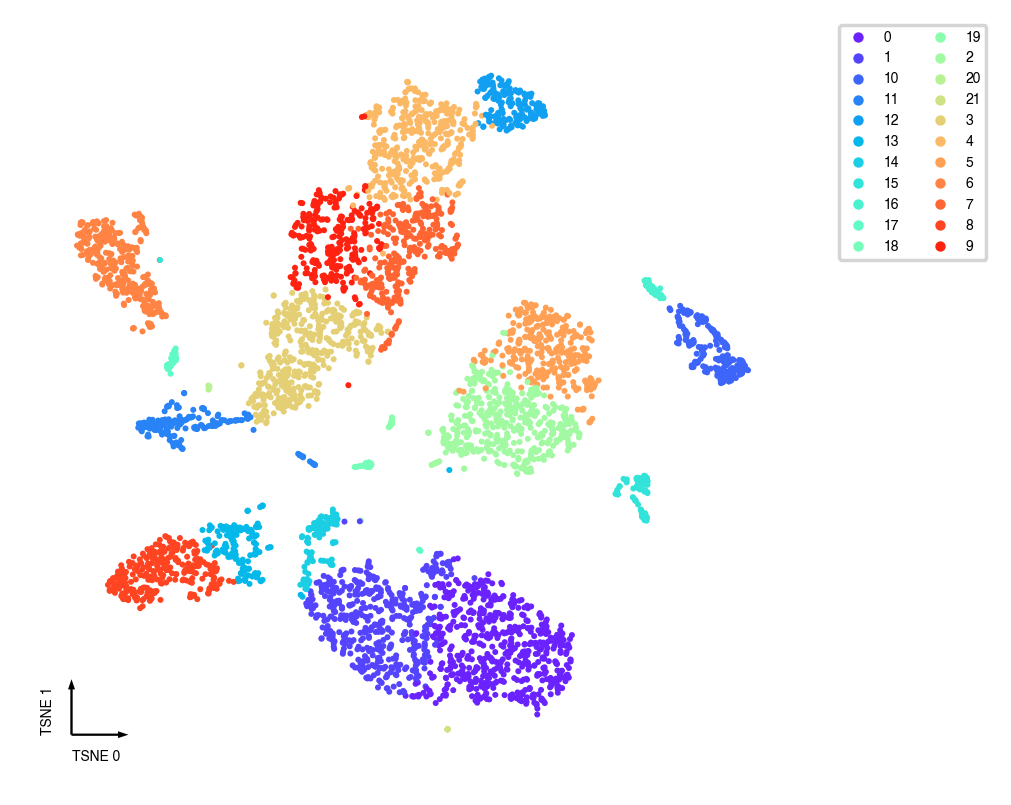

In [21]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
categorical_scatter(data=mcad, ax=ax, coord_base='tsne', hue='leiden', show_legend=True)

### UMAP

In [22]:
sc.tl.umap(mcad)

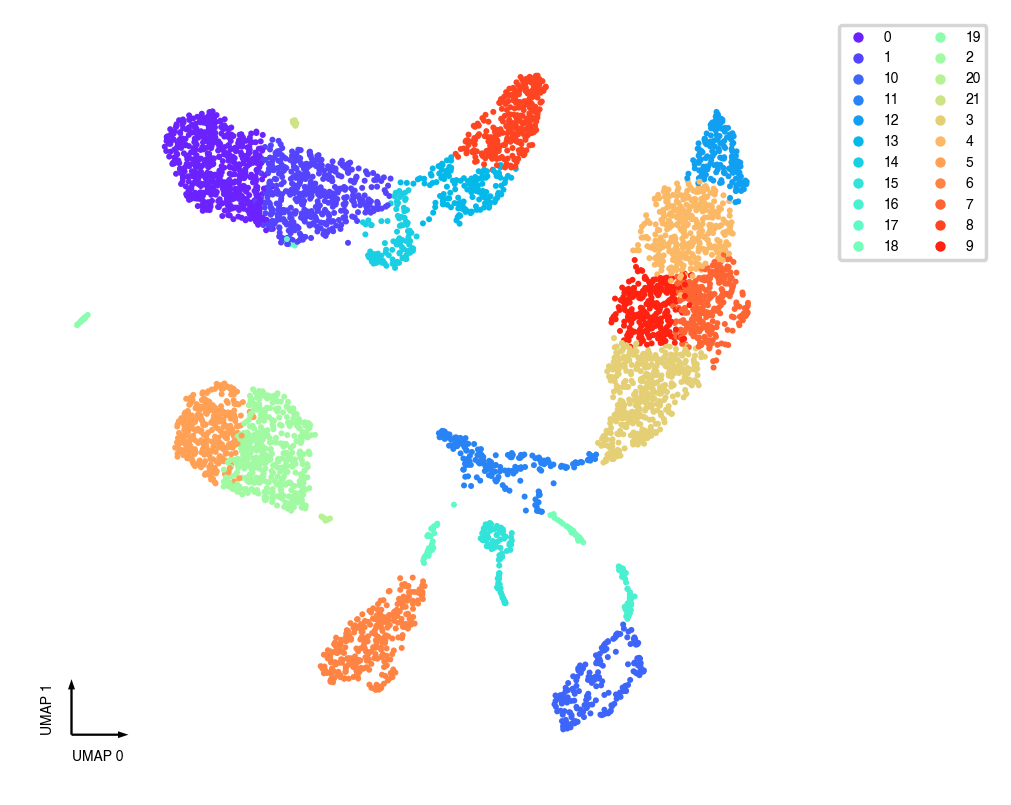

In [23]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
categorical_scatter(data=mcad, ax=ax, coord_base='umap', hue='leiden', show_legend=True)

### Interactive Scatter

In [24]:
interactive_scatter(data=mcad, hue='leiden', coord_base='umap')

## Save results

In [25]:
mcad.write_h5ad(f'adata.with_coords.mcad')
mcad

AnnData object with n_obs × n_vars = 4875 × 252901
    obs: 'AllcPath', 'mCCCFrac', 'mCGFrac', 'mCGFracAdj', 'mCHFrac', 'mCHFracAdj', 'FinalReads', 'InputReads', 'MappedReads', 'DissectionRegion', 'BamFilteringRate', 'MappingRate', 'Plate', 'Col384', 'Row384', 'FANSDate', 'Slice', 'Sample', 'leiden'
    var: 'chrom', 'end', 'start'
    uns: 'neighbors', 'leiden', 'umap'
    obsm: 'X_lsi', 'X_tsne', 'X_umap'
    obsp: 'distances', 'connectivities'